# VaR in continuous return models.

In the following we use Bayesian estimation methodology to estimate two models. First, the returns are assumed to evolve as in the BS model. Second, returns are modelled with stochastic volatility. Finally we use the estimated models to forecast day ahead VaR/ES.

## Part 1. BS model

The model is given by:
$$S_tdt = S_t\mu dt + S_t \sigma dW_t$$ 
and has a solution for log-returns $Y_t$: 
$$Y_t = \mu + \sigma (W_t - W_{t-1})$$. 

We are interested in estimating $\mu, \sigma^2$, in the Bayesian settup we want to find distribution $p(\mu, \sigma^2 \mid Y_{1:T})$. Although its not necessary we can use Gibbs sampling to break down sampling from join distribution into sampling from two conditional distributions:
$$p(\mu \mid \sigma^2, Y_{1:T})$$ and $$p(\sigma^2 \mid \mu, Y_{1:T})$$

To obtain $p(\mu, \sigma^2 \mid Y_{1:T})$ we utilize that repeteadly drawing from distributions above, each time using previous draws generates a Markov Chain which converges in distribution to $p(\mu, \sigma^2 \mid Y_{1:T})$. The algorithm becomes:

1. Set initial $\mu$ as $\mu^{(0)}$ (and $\sigma^2$ as well)
2. Draw $\sigma^{2, (1)}$ from $p(\sigma^2 \mid \mu^{(0)}, Y_{1:T})$
3. Draw $\mu^{(1)}$ from $p(\mu \mid \sigma^{2, (1)}, Y_{1:T})$
4. Repeat steps 2 and 3 S times to generate a Markov Chain.
5. Find estimates for $\mu, \sigma^2$ using means of the samples.

Lastly for steps 2 and 3 we use Bayes rule. We have that:
$$p(\mu \mid \sigma^2, Y) \propto p(Y \mid \mu, \sigma^2) p(\mu)$$
$$p(\sigma^2 \mid \mu, Y) \propto p(Y \mid \mu, \sigma^2) p(\sigma^2)$$

So that we can obtain our samples by sampling from priors and multiplying by likelihoods. In the following we assume natural conjugate priors for $\mu$ - Normal distribution and for $\sigma^2$ - Inverse Gamma distribution. For these distributions, parameters can be set using other empirical research.

In that case we can draw $\mu$ from $N(\frac{\frac{1}{\sigma^2} \sum(Y) + \frac{\mu_{\mu}}{\sigma^2_{\mu}}}{\frac{T}{\sigma^2} + \frac{1}{\sigma^2_{\mu}}}, \frac{1}{\frac{T}{\sigma^2} + \frac{1}{\sigma^2_{\mu}}})$


While to draw $\sigma^2$ we first draw from gamma with shape$ = a_0 + T/2$ and scale = $\frac{1}{b_0 + 0.5 * \sum_{t=1}^T(Y_t - \mu)^2}$ then take inverse of that as a simulation for $\sigma^2$. 

In [1]:
# Imports
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm, gamma

First we simulate data to later examine whether MCMC procedure is working correctly.

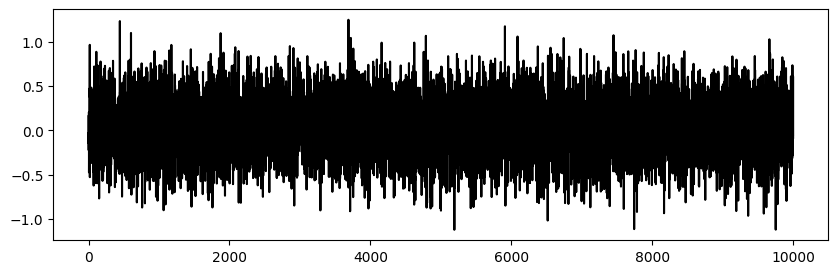

In [4]:
# Simulate sample 
mu = 0.04
sigma2 = 0.1
T = 10000
Y = np.random.normal(loc=mu, scale=np.sqrt(sigma2), size=T)
plt.figure(figsize=(10, 3));
plt.plot(Y, c='black');

In [5]:
print('Unconditional mean: ', np.mean(Y))
print('Unconditional variance: ', np.var(Y))

Unconditional mean:  0.037745609593392716
Unconditional variance:  0.09713433242894136


Now we define a function which returns samples from joint distribution $p(\mu, \sigma^2 \mid Y)$ as described in the introduction.

In [17]:
def estimate_BS_Gibbs(burn_in, n_draws, rets, mu_init, sigma2_init):
    T = len(rets)
    total_draws = burn_in + n_draws
    mu_store = np.zeros(total_draws)
    sigma2_store = np.zeros(total_draws)
    mu_store[0] = mu_init
    sigma2_store[0] = sigma2_init

    # Prior hyperparameters:
    mu_mu = 0.05
    sigma2_mu = 1.
    shape_a0 = 3.
    scale_b0 = 0.5

    for s in range(total_draws-1):
        if s % 10000 == 0:
            print(f"Current progress: {s}", end='\r')
        # Sample sigma2
        resid = rets - mu_store[s]
        shape = shape_a0 + T/2
        rate = scale_b0 + 0.5 * np.sum(resid**2)  # rate = b, NOT 1/b
        
        sigma2_store[s+1] = 1 / np.random.gamma(shape=shape, scale=1/rate)
        
        # Sample mu
        
        loc = (1 / sigma2_store[s+1] * np.sum(rets) + mu_mu / sigma2_mu) / (T / sigma2_store[s+1] + 1 / sigma2_mu)
        scale = np.sqrt(1 / (T / sigma2_store[s+1] + 1 / sigma2_mu))
        mu_store[s+1] = np.random.normal(loc=loc, scale=scale, size=1)

    
    return mu_store, sigma2_store

We now set parameters and evaluate the procedure on simulated data.

In [7]:
burn_in = 100000
n_draws = 1000000
mu_init = 0.05
sigma2_init = 0.01

In [8]:
mu_dist, sigma2_dist = estimate_BS_Gibbs(burn_in, n_draws, Y, mu_init, sigma2_init)

Use averages as point estimates for $\mu, \sigma^2$.

In [9]:
mu_hat = np.mean(mu_dist[burn_in:])
sigma2_hat = np.mean(sigma2_dist[burn_in:])
print('estimated mu ', mu_hat)
print('estimates sigma2 ', sigma2_hat)
print('estimated sigma ', np.sqrt(sigma2_hat))

estimated mu  0.03774598507259458
estimates sigma2  0.09720625921016725
estimated sigma  0.3117791834137861


We can plot the sequence of draws for $\mu, \sigma^2$. If the process is stationary then we can say that the Markov Chain has converged and we have successfully obtained the draws from $p(\mu, \sigma^2 \mid Y)$.

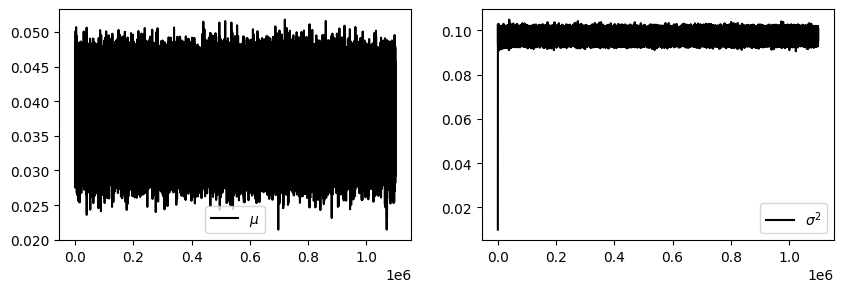

In [11]:
fig, axes = plt.subplots(1,2, figsize=(10,3));
axes[0].plot(mu_dist, label=r'$\mu$', c='black');
axes[0].legend(); plt.grid();
axes[1].plot(sigma2_dist, label = r'$\sigma^2$', c='black');
axes[1].legend(); plt.grid();

## Part 2. Stochastic volatility model

The basic stochastic volatility model for returns is:
$$Y_t \sim N(0, \sigma^2_t)$$
$$h_t = log(\sigma^2_t) = h_{t-1} + \epsilon_t \hspace{3ex} \epsilon \sim N(0, G)$$

This structure allows us to interpret model as a state-space model, the first equation is often called observation-equation while the second is called state-equation. The general framework remain similar however, we now treat every $h_t$ as 'parameter' that needs to be estimated. Additionally we have to estimate $G$.

We now want to sample from $p(h_{1:T}, G \mid Y_{1:T})$ which is a $T+1$-dimensional distribution. We use Gibbs samplin again to simplify the problem to simulating from only one-dimensional distributions. Subsequently we are interested in drawing from: 
$$p(G \mid h_{1:T}, Y_{1:T})$$
$$p(h_t \mid G, Y_{1:T}, h_{1:t-1}, h_{t+1:T}) \hspace{3ex} \forall t \in \{1, 2, ... T\}$$

We start with 
$$p(G \mid h_{1:T}, Y_{1:T}) \propto p(h_{1:T} \mid Y_{1:T}, G)p(G)$$

If we choose inverse gamma prior for G the situation becomes as in BS model from part 1 hence sampling is straightforward.

For each log-volatility we obtain:
$$p(h_t \mid G, Y_{1:T}, h_{1:t-1}, h_{t+1:T}) \propto p(Y_{1:T} \mid h_{1:T}, G)p(h_{1:T})=p(Y_{1:T} \mid h_{1:T}, G) p(h_{T} \mid h_{1:T-1})p(h_{T-1} \mid h_{1:T-2}) \ldots p(h_1 \mid h_0)$$

We can neglect terms that do not depend on $h_t$ to get:
$$p(h_t \mid G, Y_{1:T}, h_{1:t-1}, h_{t+1:T}) \propto p(Y_{t} \mid h_{t}, G) p(h_{t} \mid h_{t-1}) p(h_{t+1} \mid h_t)$$

All these distributions are normal and (dropping terms without $h_t$) we get:
$$p(h_t \mid G, Y_{1:T}, h_{1:t-1}, h_{t+1:T}) \propto \frac{1}{\sqrt{e^{h_t}}}e^{-\frac{1}{2}\frac{Y_t^2}{e^{h_t}}}e^{-\frac{1}{2}\frac{(h_t - h_{t-1})^2}{G}}e^{-\frac{1}{2} \frac{(h_{t+1} - h_t)^2}{G}}$$

Since this is not a kernel of a known distribution we use Metropolis-Hastings method to sample from it. The first step is to compute:
$$R = \frac{p(h^*)}{p(h_t)}$$ 
where $h^*$ is a random draw from some distribution and we can compute probabilities by multiplying exponential functions above. We then accept $h^*$ as a simulation for $h_t$ if a draw from a uniform distribution is less than $R$, otherwise set $h_t$ to be the same as in the previous repetition of the MCMC algorithm.

Ultimately the procedure is as follows:
1. Set initial values for each parameter i.e. $G, h_0, h_1, \ldots h_T$. 
2. Draw $h_t$ for each $t$ using Metropolis-Hastings
3. Draw G
4. Repeat steps $2$ and $3$ until convergence.

Some attention needs to be given when estimating first and last log-volatility 

Below, we implement the estimation procedure for simulated data.

In [12]:
# Simulate data:
G = 0.01
T = 250
h_sim = np.zeros(T)
h_sim[0] = 0.
Y_sim = np.zeros(T)
eps = np.random.normal(loc=0, scale = np.sqrt(G), size=T)
for i in range(T-1):
    h_sim[i+1] = h_sim[i] + eps[i]
Y_sim = np.sqrt(np.exp(h_sim)) * np.random.normal(loc=0, scale=1, size=T)

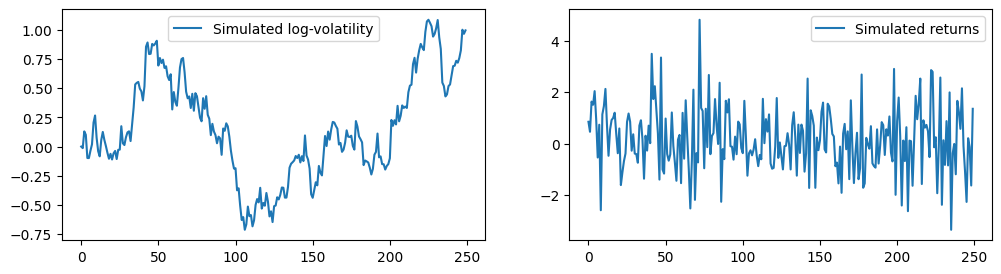

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(h_sim, label= 'Simulated log-volatility')
axes[1].plot(Y_sim, label= 'Simulated returns')
axes[0].legend();axes[1].legend()

Define a function that estimates the stoch. vol model.

In [3]:
def function0(yt, h, h_minus, h_plus, G):
    value = 1 / (np.sqrt(np.exp(h))) * np.exp(- 0.5 * yt**2 / np.exp(h)) * np.exp(- 0.5 * (h - h_minus)**2 / G) * np.exp(- 0.5 * (h_plus - h)**2 / G)
    return value

def function1(yt, h, h_minus, G):
    value = 1 / (np.sqrt(np.exp(h))) * np.exp(- 0.5 * yt**2 / np.exp(h)) * np.exp(- 0.5 * (h - h_minus)**2 / G)
    return value


In [34]:
def stoch_vol_MCMC(burn_in, n_draws, Y_sim, starting_G, starting_h):
    T = len(Y_sim)
    # Data store
    h_store = np.zeros(shape=(burn_in + n_draws, T))
    h_store[0, :] = starting_h + np.random.normal(loc=0, scale=0.01, size=T) ## add noise
        
    G_store = np.zeros(burn_in + n_draws)
    G_store[0] = starting_G
    h0_store = np.zeros(burn_in + n_draws)
        
    # Chain:
    for s in range(1, burn_in+n_draws): # step 's' s in [1, burn_in + n_draws +1) = [1, burn_in + n_draws] = [1, 10500]
        if s % 100 == 0:
            print(f"Current progress: {s / (burn_in + n_draws)}", end='\r')
            
        # Find first log-volatility:
        # Here we need to draw a log-volatility that preceedes it since this value is not included in the length of the time series.
        # We assume for it uninformative prior, then likelihood is a normal distribution with mean set to first log-volatility and variance G from previous iteration
        draw_h0 = norm.rvs(loc = h_store[s-1, 0], scale = np.sqrt(G_store[s-1]), size=1)
        # Then we apply Metropolis-Hastings but with one less term as it doesn't appear in the prior. 
        X_star = norm.rvs(loc = h_store[s-1, 0], scale = 0.5, size=1) # M-H
        R_nom = function0(Y_sim[0], X_star, draw_h0, h_store[s-1, 0+1], G_store[s-1])
        R_denom = function0(Y_sim[0], h_store[s-1, 0], draw_h0, h_store[s-1, 0+1], G_store[s-1])
        R = R_nom / R_denom
        U = np.random.uniform()
        if U <= R:
            h_store[s, 0] = X_star
        else:
            h_store[s, 0] = h_store[s-1, 0]
        
        for t in range(1, T-1): # t in range [1, T-1) = [1, T-2]
            X_star = norm.rvs(loc = h_store[s-1, t], scale = 0.5, size=1)
            R_nom = function0(Y_sim[t], X_star, h_store[s, t-1], h_store[s-1, t+1], G_store[s-1])
            R_denom = function0(Y_sim[t], h_store[s-1, t], h_store[s, t-1], h_store[s-1, t+1], G_store[s-1])
            R = R_nom / R_denom
            U = np.random.uniform()
            if U <= R:
                h_store[s, t] = X_star
                    
            else:
                h_store[s, t] = h_store[s-1, t]
                    
        # When drawing last log-volatility we also use Metropolis-Hastings. As for the first log-volatility one of the terms in the prior drops out.
        X_star = norm.rvs(loc = h_store[s-1, T-1], scale = 0.5, size=1)
        R_nom = function1(Y_sim[T-1], X_star, h_store[s, T-2], G_store[s-1])
        R_denom = function1(Y_sim[T-1], h_store[s-1, T-1], h_store[s, T-2], G_store[s-1])
        R = R_nom / R_denom
        U = np.random.uniform()
        if U <= R:
            h_store[s, T-1] = X_star
        else:
            h_store[s, T-1] = h_store[s-1, T-1]
        
        # Find variance of the variance
        shape = T / 2 + 1
        scale = 2 / (np.sum((h_store[s, 2:] - h_store[s, 1:-1])**2) + (h_store[s, 1] - draw_h0)**2)
        Z = np.random.gamma(shape = shape, scale = scale)
        G_store[s] = 1 / Z

    return h_store, G_store

In [16]:
starting_h = np.log(np.var(Y_sim))
starting_G = 0.05
burn_in = 25000 # number of draws before 'real draws'
n_draws = 100000 # number of draws for each h
h0 = starting_h
h_store, G_store = stoch_vol_MCMC(burn_in, n_draws, Y_sim, starting_G, starting_h)

As the point estimates for each log-volatility and G we use averages of the samples generated from the MCMC.

In [17]:
h_hat = np.mean(h_store[burn_in:, :], axis=0)
G_hat = np.mean(G_store[burn_in:])

Estimated G:  0.007019910323927755 
 True G:  0.01


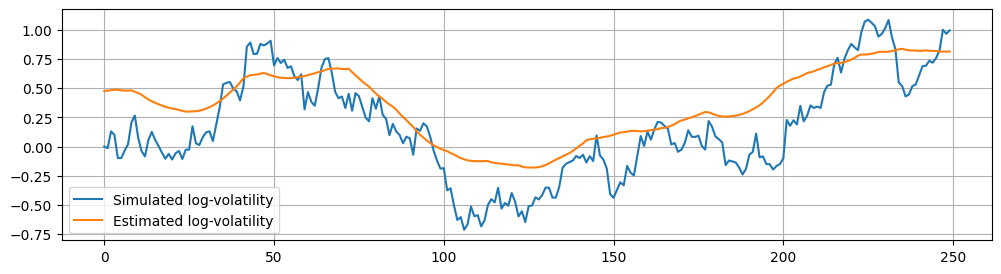

In [18]:
plt.figure(figsize=(12, 3))
plt.plot(h_sim, label='Simulated log-volatility');
plt.plot(h_hat, label='Estimated log-volatility');
print('Estimated G: ', G_hat , '\n True G: ', G)
plt.grid();plt.legend()

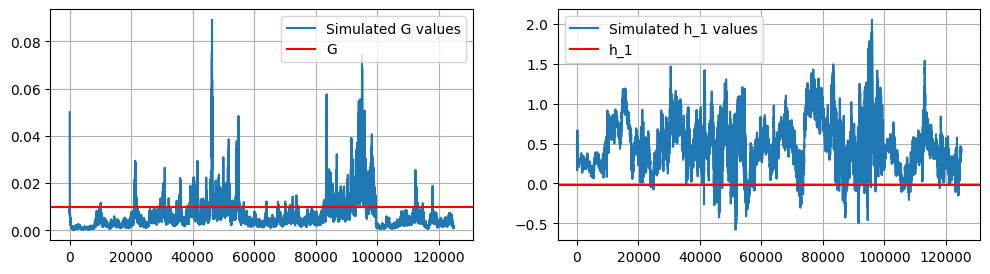

In [19]:
# Plot all samples to examine the convergence of the MCMC.
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(G_store[:], label='Simulated G values')
axes[0].axhline(G, c='red', label='G')
axes[0].grid();axes[0].legend()
axes[1].plot(h_store[:, 1], label='Simulated h_1 values')
axes[1].axhline(h_sim[1], label='h_1', c='red')
axes[1].grid();axes[1].legend()


Based on plots above we can also adjust our point estimates by taking averages starting with the values where the chain is stationary. Plots above suggest that the number of MCMC simulations most likely should be still larger. Ideally also sample size should be larger.

In general the MCMC algorithm performs better as the sample size (T) gets larger. Within finite sample some deviation from the true values is expected.

The potential issues with basic stochastic volatility model is that log-volatility can potentially explode. This can also rise problems during the estimation. As a solution we might consider a model with mean-reverting volatility to avoid explosions. Finally, the code written above can be substantially improved. First a few hyperparameters are used in a ad-hoc manner while some theoretical candidates can be proposed. Second, the starting values we use for h are all set to unconditional log-variance of the series. However, we might be able to come up with better ideas, e.g. log-square roots of returns.

## Part 3 Forecasting day-ahead Value-at-risk

We now apply the models and estimation procedure from above to DAX data and create day-ahead VaR forecasts. 

In [5]:
# Import data:
path = 'datasets/DAX_daily_prices.xlsx'
data = pd.read_excel(path)
data.columns = ['Date', 'DAX']
dates = pd.to_datetime(data['Date'], format='%Y-%m-%d')
prices = np.array(data["DAX"])[::-1] # as prices were ordered from newest to oldest
losses = - np.diff(np.log(prices)) # losses are defined as negative returns

We will limit ourselves to last 1000 observations to decrease computation time.

In [6]:
prices = prices[-1001:]
rets = np.diff(np.log(prices))*100 # Multiply by 100 for numerical stability

Unconditional mean:  0.035224487145455896 
Unconditional variance:  1.0551599144798287


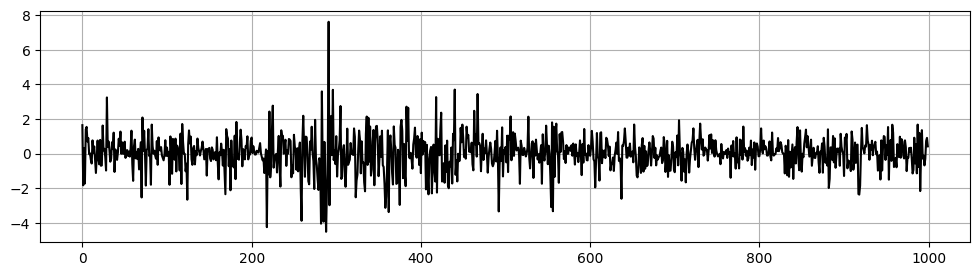

In [7]:
plt.figure(figsize=(12, 3));plt.plot(rets, c='black');plt.grid()
print('Unconditional mean: ', np.mean(rets), '\nUnconditional variance: ', np.var(rets))

In [18]:
# Define parameters
burn_in = 200000
n_draws = 1000000
mu_init = 0.
sigma2_init = 0.01

In [19]:
mu_store_BS, sigma2_store_BS = estimate_BS_Gibbs(burn_in, n_draws, rets, mu_init, sigma2_init)
mu_hat_BS, sigma2_hat_BS = np.mean(mu_store_BS[burn_in:]), np.mean(sigma2_store_BS[burn_in:])
print('Estimated mu:', mu_hat_BS, '\nEstimated sigma^2: ', sigma2_hat_BS)

Estimated mu: 0.035222065479289175 
Estimated sigma^2:  1.052942997637435


In [20]:
print('Unconditional mean,  variance and standard deviation:', np.mean(rets), np.var(rets), np.sqrt(np.var(rets)))

Unconditional mean,  variance and standard deviation: 0.035224487145455896 1.0551599144798287 1.027209771409827


As in the case of simulated data, estimates converged to unconditional moments.

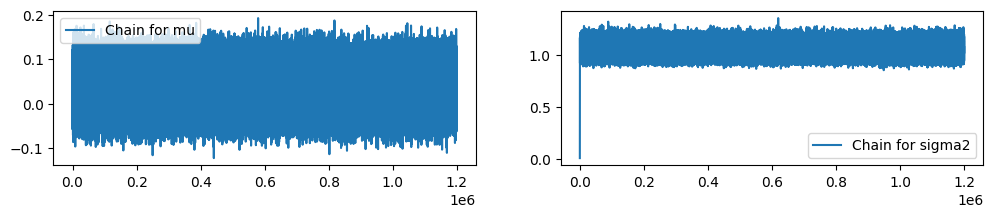

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 2))
axes[0].plot(mu_store_BS, label='Chain for mu');axes[0].legend(loc='upper left')
axes[1].plot(sigma2_store_BS, label='Chain for sigma2');axes[1].legend()

Using estimated parameters we generate next-day distribution of returns. Then compute 99% VaR as 0.99th quantile of losses or 0.01th quantile of returns.

In [22]:
M = 10000
T = len(rets)
rets_BS_day_ahead = np.zeros(shape=(M, T))
eps = np.random.normal(loc=0, scale=1, size=(M, T))
rets_BS_day_ahead = mu_hat_BS + np.sqrt(sigma2_hat_BS)*eps
VaR_forecast_BS = np.quantile(rets_BS_day_ahead, 0.05, axis=0)

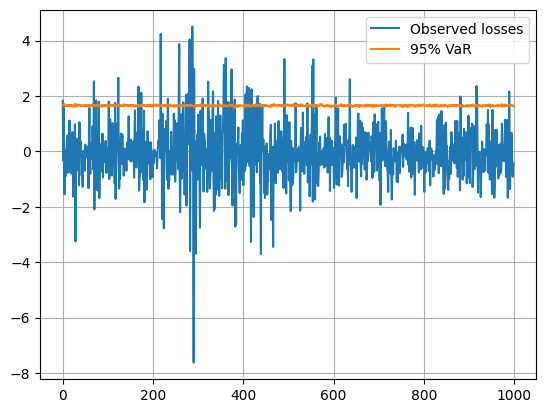

In [23]:
plt.plot(-rets[1:], label='Observed losses')
plt.plot(-VaR_forecast_BS, label='95% VaR')
plt.legend();plt.grid()

In [24]:
np.mean(np.where(-VaR_forecast_BS[:-1] < -rets[1:], 1, 0))

0.057057057057057055

The Gaussian strusture of the BS model does not permit a fat-tailed distribution for returns. This results in slightly underestimated VaR since empirically returns over finite time horizons have fat-tailed distributions.

We now do the same but using stochastic volatility model for returns.

In [9]:
# Estimate the model:
burn_in = 75000
n_draws = 250000
starting_G = 0.01
starting_h = 0.2

In [10]:
h_store, G_store = stoch_vol_MCMC(burn_in, n_draws, rets, starting_G, starting_h)

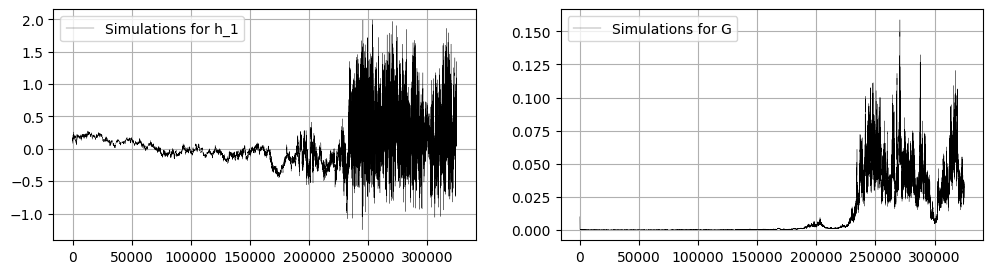

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(h_store[:, 1], label='Simulations for h_1', c='black', lw=0.2);axes[0].legend();axes[0].grid()
axes[1].plot(G_store[:], label='Simulations for G', c='black', lw=0.2);axes[1].legend();axes[1].grid()

It is unclear whether the model parameters started to converge. As a check-up we will use average of the final part of the simulations as a starting values and re-run the function. This should be approximately equivalent to running previous chain longer.

In [29]:
# Take point estimates:
h_hat = np.mean(h_store[240000:, :], axis=0)
G_hat = np.mean(G_store[240000:])

In [35]:
starting_G_cont = G_hat
starting_h_cont = h_hat
burn_in = 50000
n_draws = 100000
h_store_cont, G_store_cont = stoch_vol_MCMC(burn_in, n_draws, rets, starting_G_cont, starting_h_cont)

We examine the convergence again:

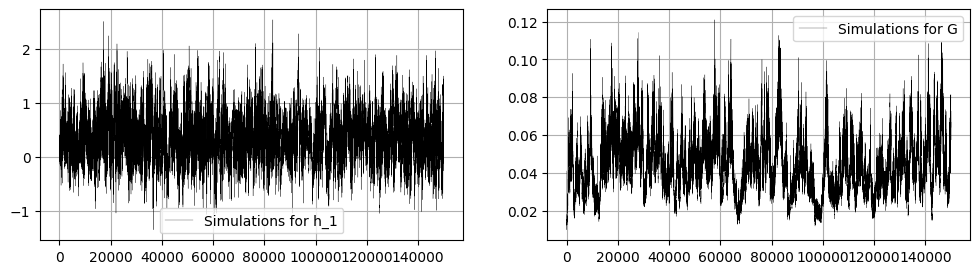

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(h_store_cont[:, 1], label='Simulations for h_1', c='black', lw=0.2);axes[0].legend();axes[0].grid()
axes[1].plot(G_store_cont[:], label='Simulations for G', c='black', lw=0.2);axes[1].legend();axes[1].grid()

This series looks stationary and in fact it seems like the chain has converged. We will use the point estimates based on the averages of second simulation.

In [38]:
h_hat = np.mean(h_store_cont[20000:, :], axis=0)
G_hat = np.mean(G_store_cont[20000:])

Then proceeding as in the other model, we compute values at risk using simulated returns.

In [39]:
# Forecast day-ahead returns:
M = 10000
T = len(rets)
rets_SV_day_ahead = np.zeros(shape=(M, T))
h_day_ahead = np.zeros(shape = (M, T))
eps = np.random.normal(loc=0, scale=np.sqrt(G_hat), size=(M, T))
eps2 = np.random.normal(loc=0, scale=1, size=(M, T))
for t in range(0, T):
    h_day_ahead[:, t] = h_hat[t] + eps[:, t]
    rets_SV_day_ahead[:, t] = np.sqrt(np.exp(h_day_ahead[:, t])) * eps2[:, t]

In [40]:
var_SV = np.quantile(rets_SV_day_ahead, 0.05, method='inverted_cdf', axis=0)

And finally we compute the exceedences as a simple check for VaR. Also we plot together the day-ahead VaRs from both models for comparison. 

In [41]:
print('SV VaR, percentage of exceedences: ', np.mean(np.where(var_SV[:-1] > rets[1:], 1, 0)))

SV VaR, percentage of exceedences:  0.04904904904904905


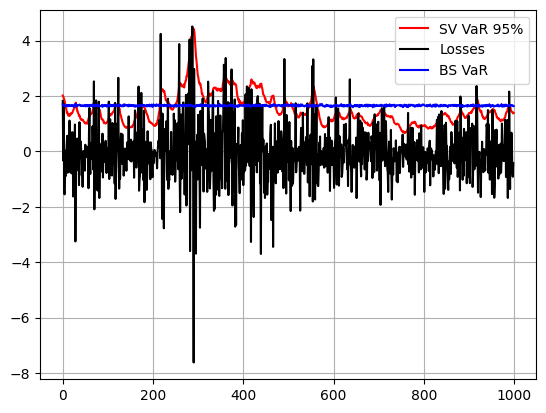

In [42]:
plt.plot(-var_SV, label='SV VaR 95%', c='red')
plt.plot(-rets[1:], label='Losses', c='black')
plt.plot(-VaR_forecast_BS, label='BS VaR', c='blue')
plt.legend()
plt.grid()

Due to time varying volatility, the SV model effectively produces risk measures that are adaptive to the market conditions. This is a great advantage as we see that SV model has less exceedenced than BS model while at the same time giving VaR forecasts that are less than in the BS model.